### Создание веб-сервиса определения породы животного

В данном jupyter-ноутбуке попробуем подготовить RESTful сервис, к которому на вход поступает фотография питомца, а на выходе название породы, к которой он относится

Прежде чем начать установим необходимые для дальнейшей работы Python модули и дополнительные компоненты

In [1]:
! pip3 install matplotlib
! pip3 install numpy
! pip3 install pandas
! pip3 install tqdm
! pip3 install torch==2.0.0+cpu torchvision==0.15.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html


#### Теперь скачаем и распакуем данные для обучения

In [2]:
! wget -O data.zip 'https://downloader.disk.yandex.ru/disk/02c5fc8cc11d845572a9c8597199d2ced7345d4e555cd04aa3f992862049488f/65288bbb/qo_oUU0UNiEpD-z6-zCIgUCJWGUJQ0diMJpW3abybWGWekAG9JqDwcG5P3iWjoFH41RAY_UlNjc23xWQoYg-Ww%3D%3D?uid=0&filename=data.zip&disposition=attachment&hash=CBCGA7YVyxnH5MdM49x5dTmXtMsJE907/X6Hpv33VJIHsuF8lCh6mpf2CyTCgzGVq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/data.zip&limit=0&content_type=application%2Fzip&owner_uid=1199758960&fsize=735487790&hid=830bd62217b156189a95673e2f77d49e&media_type=compressed&tknv=v2'

--2023-10-12 22:13:53--  https://downloader.disk.yandex.ru/disk/02c5fc8cc11d845572a9c8597199d2ced7345d4e555cd04aa3f992862049488f/65288bbb/qo_oUU0UNiEpD-z6-zCIgUCJWGUJQ0diMJpW3abybWGWekAG9JqDwcG5P3iWjoFH41RAY_UlNjc23xWQoYg-Ww%3D%3D?uid=0&filename=data.zip&disposition=attachment&hash=CBCGA7YVyxnH5MdM49x5dTmXtMsJE907/X6Hpv33VJIHsuF8lCh6mpf2CyTCgzGVq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/data.zip&limit=0&content_type=application%2Fzip&owner_uid=1199758960&fsize=735487790&hid=830bd62217b156189a95673e2f77d49e&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8::2:127
Connecting to downloader.disk.yandex.ru (downloader.disk.yandex.ru)|77.88.21.127|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s196vlx.storage.yandex.net/rdisk/02c5fc8cc11d845572a9c8597199d2ced7345d4e555cd04aa3f992862049488f/65288bbb/qo_oUU0UNiEpD-z6-zCIgUCJWGUJQ0diMJpW3abybWGWekAG9JqDwcG5P3iWjoFH41RAY_UlNjc23xWQoYg-Ww==?uid=0&fi

In [3]:
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall("data")

Подключим все необходимые для дальнейшей работы python-библиотеки

In [3]:
%matplotlib inline
import os
import time
import json
import torch
import tqdm
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

warnings.filterwarnings('ignore') 

Посмотрим сколько всего имеется данных и как они выглядят

In [4]:
# директория, в которой располагаются данные
DATA_DIR = 'data/dog-breed-identification/'

In [5]:
labels = pd.read_csv(os.path.join(DATA_DIR, 'labels.csv'))
size_of_images = len(os.listdir(os.path.join(DATA_DIR, 'train')))
size_of_labels = len(labels)

print(f"Количество изображений в обучающем множестве: {size_of_images} и количество меток {size_of_labels}")


Количество изображений в обучающем множестве: 10222 и количество меток 10222


In [6]:
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
# В папке train содержаться изображения с именами с форматами id из labels
os.listdir(os.path.join(DATA_DIR, 'train'))[:5]

['c5928c863685a331b3fc2c16193a72ae.jpg',
 'e62630fa77dea4ee5a100e23edc6d061.jpg',
 '6ad3158a68c2595ff6b1a59aba2ecbe6.jpg',
 '1a954490c0b303ce88e54c727937e745.jpg',
 'ffd25009d635cfd16e793503ac5edef0.jpg']

In [8]:
print(f"Всего пород в датасете: {len(labels['breed'].unique())}")

Всего пород в датасете: 120


### EDA. Посмотрим на распределение данных по породам собак

In [9]:
labels.groupby('breed').count().sort_values(by='id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
komondor,67
brabancon_griffon,67
golden_retriever,67


Для более упрощения и усокорения времени обучения возьмём только топ-20 наиболее частовстречающихся пород

In [11]:
NUM_CLASSES = 20

In [12]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']

In [40]:
MAP_IDX_TO_LABEL = {
    idx: label 
    for idx, label in enumerate(sorted(labels.breed.unique()))
}
MAP_IDX_TO_LABEL

{0: 'afghan_hound',
 1: 'airedale',
 2: 'australian_terrier',
 3: 'basenji',
 4: 'beagle',
 5: 'bernese_mountain_dog',
 6: 'blenheim_spaniel',
 7: 'cairn',
 8: 'entlebucher',
 9: 'great_pyrenees',
 10: 'irish_wolfhound',
 11: 'japanese_spaniel',
 12: 'leonberg',
 13: 'maltese_dog',
 14: 'miniature_pinscher',
 15: 'pomeranian',
 16: 'samoyed',
 17: 'scottish_deerhound',
 18: 'shih-tzu',
 19: 'tibetan_terrier'}

Подготовим данные в виде one-hot представления, воспользовавшись методом pivot

In [14]:
labels_pivot = labels.pivot(index='id', columns='breed', values='target').reset_index().fillna(0)
labels_pivot.head(3)

breed,id,afghan_hound,airedale,australian_terrier,basenji,beagle,bernese_mountain_dog,blenheim_spaniel,cairn,entlebucher,...,irish_wolfhound,japanese_spaniel,leonberg,maltese_dog,miniature_pinscher,pomeranian,samoyed,scottish_deerhound,shih-tzu,tibetan_terrier
0,003df8b8a8b05244b1d920bb6cf451f9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0042188c895a2f14ef64a918ed9c7b64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,00693b8bc2470375cc744a6391d397ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Разобьём размеченное множество данных на валидацию и обучение

In [15]:
train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(1747, 21) (437, 21)


Подготовим специальный Pytorch-класс [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), который нам потребуется во время дообучения

In [17]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = f'{self.labels.iloc[idx, 0]}.jpg'
        fullname = os.path.join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

Так как данные модели были обучены на нормализованных изображениях, то при дообучении так же нужно добавить шаг нормализации.
Нормализации состоит в том, чтобы для каждого экземпляра изобаржения:
 
 - Привести к единому размеру 224 x 224px
 - Преобразовать в тип, который понятен pytorch
 - Вычесть среднее и поделить стандартное нормальное отклоенение, которые были вычесленны на основе датасета [Imagenet](https://www.image-net.org)

In [18]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
# подготовим подготовим обучающее и валидационное множества
train_ds = DogsDataset(train, os.path.join(DATA_DIR, 'train/'), transform=ds_trans)
valid_ds = DogsDataset(valid, os.path.join(DATA_DIR, 'train/'), transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)

Посмотрим на то, как теперь выглядят полученные изображения

In [19]:
def imshow(axis, inp):
    """
    При визуализации необходимо произвести
    обратные процедуре нормализации шаги
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4])


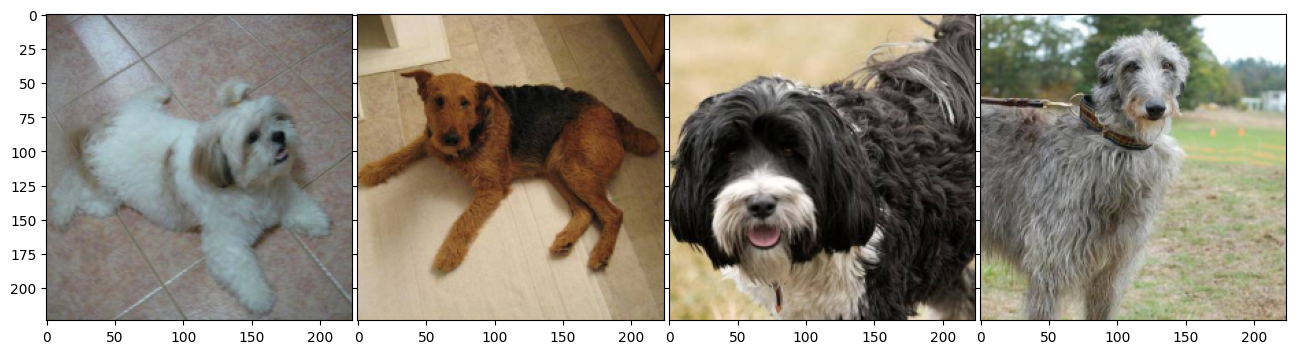

In [25]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

Скачаем предобученную модель ResNet18 из pytorch-репозитория с моделями и посмотрим на размерность выхода
В данном примере используется самая маленькая модель из семейста моделей Resnet. Данная архитектура была предложена в компаемм Microsoft и была обучена на решение задачи классификации изобаржений.
В чём особенность данных моделей можно почитать [здесь](https://databasecamp.de/en/ml/resnet-en)

In [26]:
resnet = models.resnet18(pretrained=True)
inputs, labels = next(iter(train_dl))
outputs = resnet(inputs)
outputs.size()

torch.Size([4, 1000])

Так как модель была предобучена на другом датасете с другим количеством классов, то в "сыром" виде воспользоваться ей для нашей задачи нельзя. Поэтому необходимо изменить последний слой, который отвечает за то, какой размерности будет финальный выход модели. Для этого уберём последний слой модели и на его место поставим свой, который будем дообучать на нашу задачу.

![image](https://learnopencv.com/wp-content/uploads/2019/05/transfer-learning-1024x574.jpg)

#### `Кастомизация модели под задачу`

In [27]:
# замораживаем те слои, которые не собираемся дообучать
for param in resnet.parameters():
    param.requires_grad = False

# убираем последний слой и ставим свой
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

#### `Функция обучения`

Подготовим функцию обучения. Будем для каждой эпохи запоминать, качество модели на валидации, и в конце обучения отдадим веса, на которых качество работы модели было наилучшим.

In [28]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm.tqdm(dataloders[phase]):
                
                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

Теперь всё готово, чтобы запустить обучение нашей модели

In [29]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=3)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.49it/s]


Epoch [0/2] train loss: 0.4373 acc: 0.4883 valid loss: 0.1190 acc: 0.8490


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.50it/s]


Epoch [1/2] train loss: 0.2206 acc: 0.7430 valid loss: 0.0926 acc: 0.8627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.50it/s]

Epoch [2/2] train loss: 0.1863 acc: 0.7733 valid loss: 0.0797 acc: 0.8879
Best val Acc: 0.887872
Training time:   6.812836 minutes


Посмотрим на качество предсказания на некотором валидационном подмножестве

In [32]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.data[j])
            pred_breed = MAP_IDX_TO_LABEL[int(preds[j])][:15]
            gt_breed = MAP_IDX_TO_LABEL[int(labels.data[j])][:15]
            ax.text(10, 210, f'{pred_breed}/{gt_breed}', 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

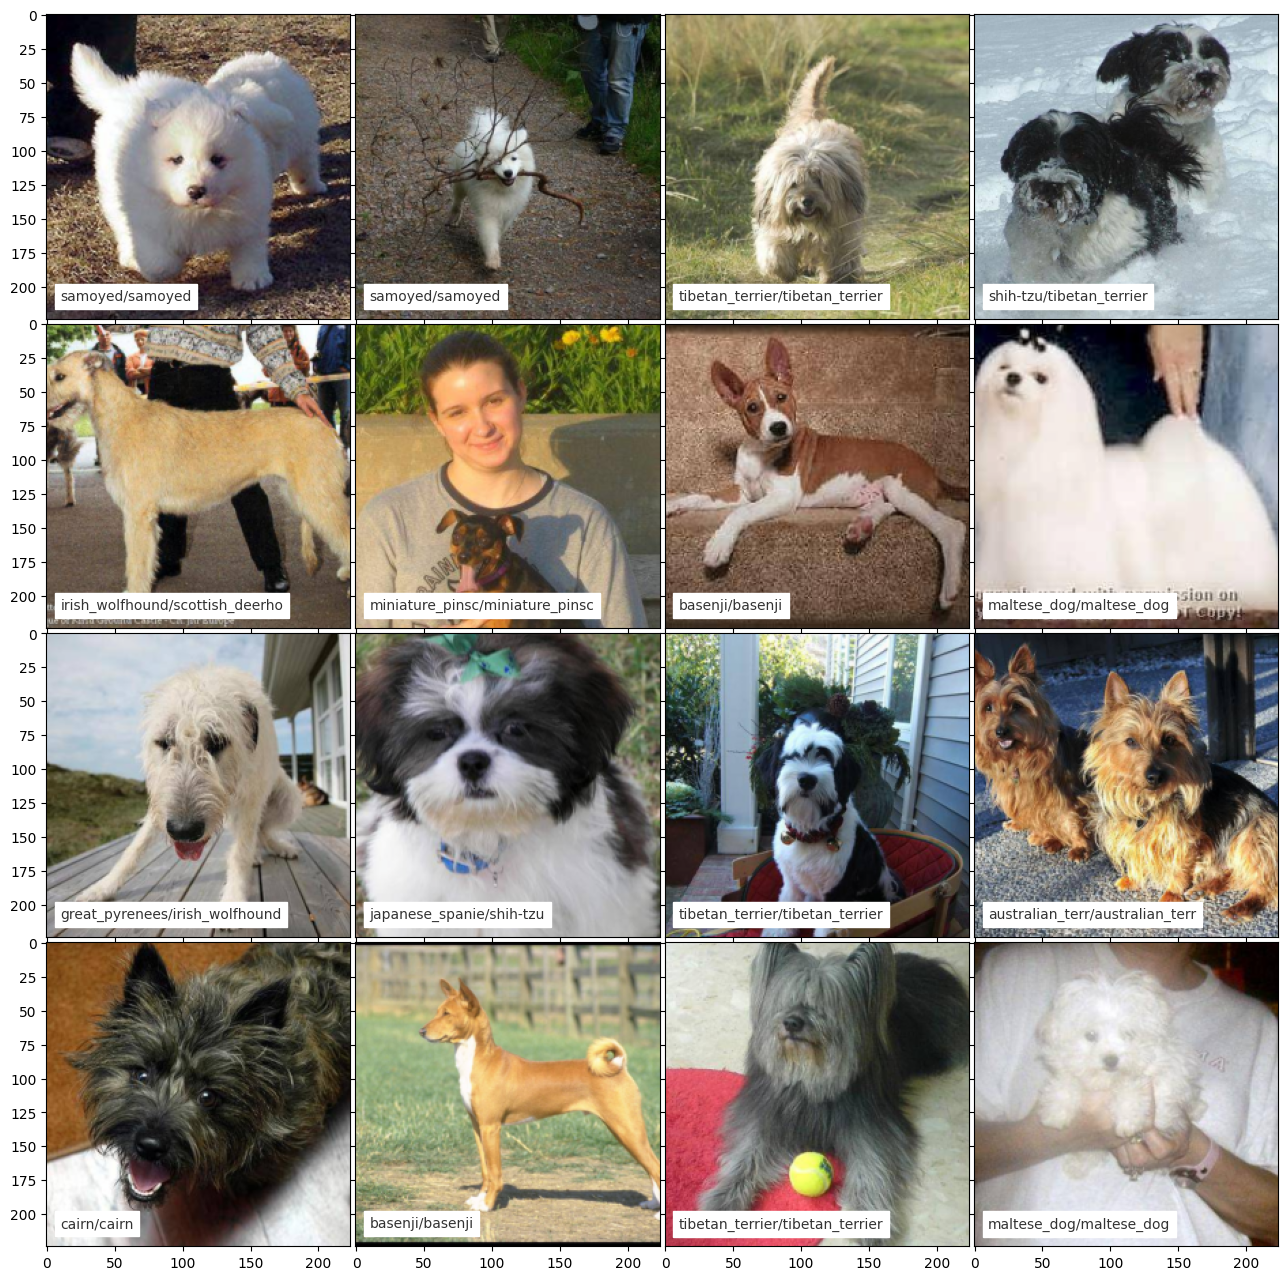

In [33]:
visualize_model(dloaders, resnet)

Сохраним обученную модель для дальнейшего использования

In [38]:
os.makedirs("models", exist_ok=True)
torch.save(
    {'model': model, 'state_dict': model.state_dict()},
    "models/finetuned_model.pth",
)

А также не забудем сохранить информацию о том, с какими породами работает модели, и как номер ответа отображается в человекочитаемое название

In [36]:
with open("models/breeds_mapping.json", 'w') as fin:
    json.dump(MAP_IDX_TO_LABEL, fin)